# Customer Churn Prediction using Experian Data

### Background

Business can purchase data from Experian to get more insight about their customers.
<br>
The data return back will reflect customer's interest, hobby, etc.

The data contain customers' subscription status and the customer's data from Experian Data. 
<br>
Subscription Status is base on after a free trial subscription. 
<br>
Active: users continue to subscripe after trial.<br>
Cancel/Expire: users op out of the subscription after trial.


### Goal

Create model to Predict Customer Churn by using the Experian Data.
Model include Logistic, Random Forest, Gardient Boost, Neural Network.
Baseline probability 0.5, Model should do better than random Guess

### Import all necessary library

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as stats
plt.style.use('seaborn')
%matplotlib inline
from collections import Counter
from scipy.stats import ks_2samp
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 

### Load and Clean
- Load the Data, remove all trailing space in column name
- Preview  the data structure

In [174]:
df = pd.read_csv("../Data/data full.csv")
df.columns = df.columns.str.strip()

In [175]:
df_num = df._get_numeric_data()
df = pd.concat([df["Sub Status"],df_num],axis =1)

In [16]:
df.head()

,Sub Status,person 1: technology adoption,person 1: mobile users,person 1: health well being,act/int: amusement park visit,act/int: zoo visit,act/int: wine lovers,act/int: do-it-yourselfers,act/int:home improve spenders,act/int: hunting enthusiasts,...,mid-range car vs trucks,iq: socialiq-social media,person id,facebook,instagram,pintrest,linkd in,twitter,snapchat,youtube
0,Active,3.0,5.0,4.0,90.0,99.0,96.0,22.0,26.0,10.0,...,7152.0,NaN,2.000071e+09,3.0,7.0,5.0,6.0,5.0,6.0,6.0
1,Active,3.0,4.0,3.0,52.0,22.0,37.0,34.0,23.0,30.0,...,9133.0,4.0,2.000427e+09,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,Expired/Cancelled,3.0,4.0,4.0,80.0,69.0,74.0,13.0,34.0,22.0,...,8820.0,6.0,2.000612e+09,3.0,6.0,3.0,5.0,6.0,7.0,5.0
3,Expired/Cancelled,4.0,3.0,3.0,69.0,78.0,45.0,25.0,6.0,20.0,...,8930.0,1.0,2.001643e+09,3.0,8.0,7.0,5.0,7.0,7.0,6.0
4,Expired/Cancelled,3.0,4.0,3.0,57.0,59.0,40.0,39.0,65.0,68.0,...,9633.0,1.0,2.000023e+09,3.0,6.0,5.0,5.0,6.0,5.0,6.0


Data Cleaning
- the Data contain 20000 rows
- some column has no data at all, which will be remove
- for most of other missing data, when data is missing, the whole row is missing as well, so all those rows will be dropped

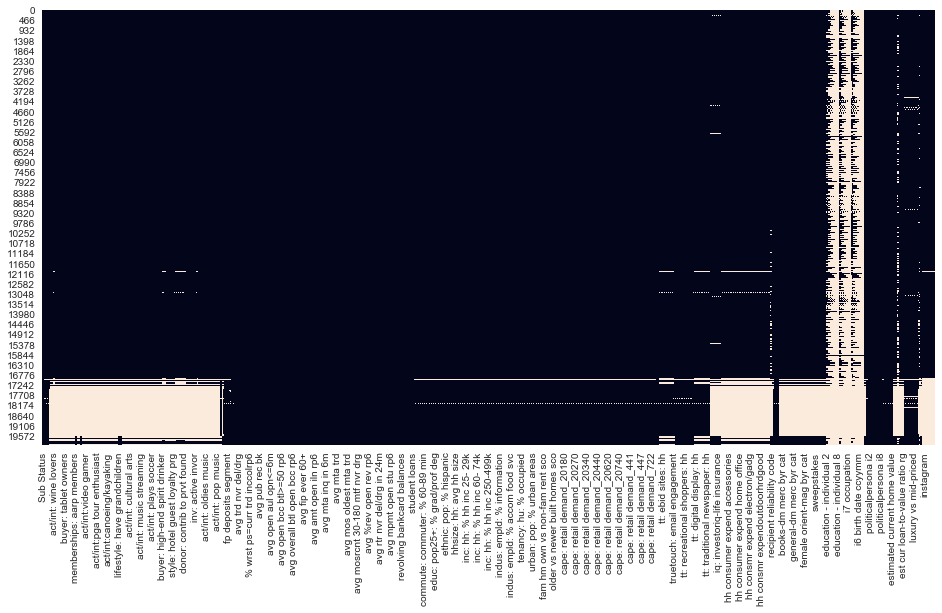

In [17]:
plt.figure(figsize=(16,8))
sns.heatmap(df.isnull(),cbar=False)

In [176]:
useless_column = df.isna().sum().sort_values()[-24:].index

In [177]:
df.drop(useless_column, axis =1,inplace=True)
df.dropna(inplace=True)

In [126]:
df.shape

(16378, 468)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16378 entries, 0 to 17247
Columns: 468 entries, Sub Status to youtube
dtypes: float64(459), int64(8), object(1)
memory usage: 58.6+ MB


In [178]:
# Split the numerical DF to two group, one with active, one with cancel
df_act = df[df["Sub Status"] == "Active"]
df_cnl = df[df["Sub Status"] == "Expired/Cancelled"]

## Exploring the data.
- create a function to plot kernel density of one numerical column.

In [23]:
# Function to plot the distribution of two group of data in the same graph.

def compare_distribution(data1,data2):
    """
    For each of input data array, 
    return a plot of kernel density of the input data.
    Both plot will be on the same graph.
    data1 will be the active group data.
    data2 will be the inactive grouop data.
    
    Parameters
    ----------
    data1: 1-dimensional Array, numpy Array, Pandas Series.
    data2: 1-dimensional Array, numpy Array, Pandas Series.

    Returns
    -------
    Plot figure.
    """
    #Finding the mean and standard deviation of both data and store them.
    mu,mu2 = np.mean(data1),np.mean(data2)
    sd,sd2 = np.std(data1),np.std(data2)
    
    plt.figure(figsize=(16,8))
    
    #Set the title and put varibale to it's name.
    
    plt.title("Active(\u03bc={0},\u03C3={1}) vs Cancel(\u03bc={2},\u03C3={3})".
              format(np.round(mu,2),np.round(sd,2),np.round(mu2,2),np.round(sd2,2)),fontsize=25)
    # Using seaborn KDE plot feature to graph both plot.
    sns.kdeplot(data1, label = "Active User")
    sns.kdeplot(data2,label ="Cancel User",alpha = 0.5)
    
    # Draw verticle dash line on the mean, anootate them.
    plt.axvline(mu, c="blue", linestyle ="--",label = "mu Active")
    plt.axvline(mu2, c="green", linestyle ="--",label = "mu Cancel")
    plt.xlabel("{} score".format(data1.name), fontsize=18)
    plt.annotate('Active mu = {}'.format(np.round(mu,2)), xy=(mu, 0),xytext=(mu-sd,0.002),arrowprops=dict(facecolor='black',width=0.2,headwidth=9))
    plt.annotate('Cancel mu = {}'.format(np.round(mu2,2)), xy=(mu2, 0),xytext=(mu2+sd2,0.002),arrowprops=dict(facecolor='black',width=0.2,headwidth=9))
    plt.legend(fontsize="large")


Calling the compare_distribution function create above will create a plot below.

By looking at the plot, we can get a better idea how the distribution of one column of numerical data looks like for each of the group. Knowing where the mean it is, and get a general idea of the difference.

For example, we can see that for the "wine lovers" column, both group has a positive skew distribution, with mode around 10, and the mean is 34.17 for the active group, 39.44 for the cancel group.  

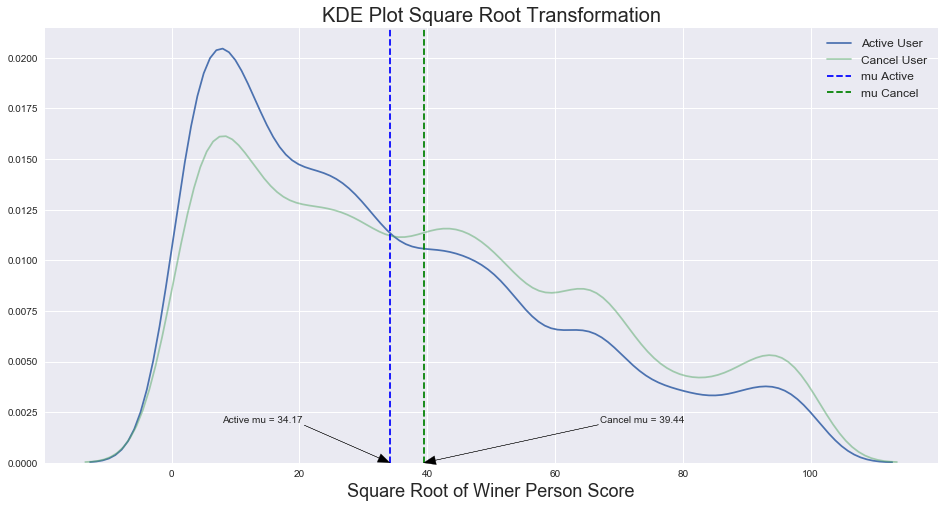

In [24]:
compare_distribution(df_act["act/int: wine lovers"],df_cnl["act/int: wine lovers"])
plt.title("KDE Plot Square Root Transformation",fontsize=20)
plt.xlabel("Square Root of Winer Person Score")
plt.savefig("../image/squareroot.png")

Using a for loop to go over every numerical column, store the image into a local image folder. 

With this, I can examine the distribution of each column individually. 

In [ ]:
count =1
for column in df.iloc[:,1:]:
    #Looping through all numerical column in the numerical DF.
    # Assign Active user data to A, Cancel User data to B
    A = df_act[column]
    B = df_cnl[column]
    #Call the compare_distribution to create the plot.
    compare_distribution(A,B)
    
    # Split the column name, use only text after ":" as image name.
    plt.savefig("../image/{}.png".format(count))
    count+=1

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Confirm all images properly store in the image folder

In [25]:
%ls "../image"

1.png           136.png         173.png         3.png           67.png
10.png          137.png         174.png         30.png          68.png
100.png         138.png         175.png         31.png          69.png
101.png         139.png         176.png         32.png          7.png
102.png         14.png          177.png         33.png          70.png
103.png         140.png         178.png         34.png          71.png
104.png         141.png         179.png         35.png          72.png
105.png         142.png         18.png          36.png          73.png
106.png         143.png         180.png         37.png          74.png
107.png         144.png         181.png         38.png          75.png
108.png         145.png         182.png         39.png          76.png
109.png         146.png         183.png         4.png           77.png
11.png          147.png         184.png         40.png          78.png
110.png         148.png         185.png         41.png          79.png
111.png

Examine each image, below are another two example of image created.
One is for "video gamer", and the other one is for "dog owner".

<img src="../image/video gamer.png">
<img src="../image/ dog owners.png">

From the above images, we can see both user group actually has pretty similar distribution shape. 
<BR>
However, for "video gamer" column, the mean is far more apart then the "dog owners" column. 

### Correlation between part of the variables
Since we are at the exploring data process, we want to see if there is any correlation between the datas. 
To do so, I decide to create a correlation heat map to identify these relationship. 

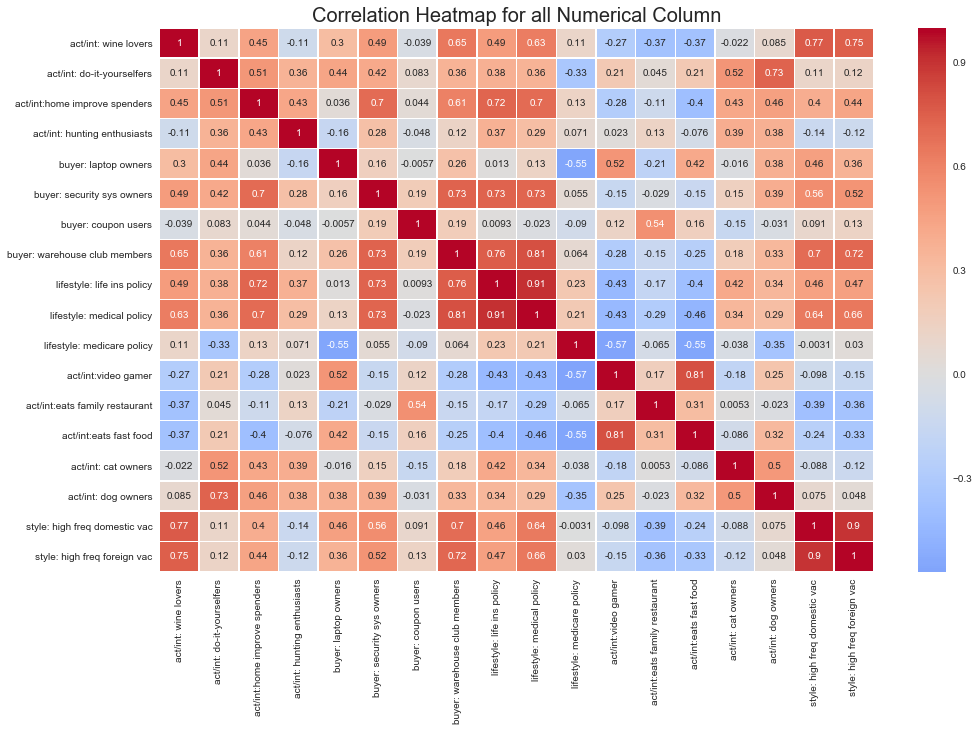

In [23]:
plt.figure(figsize=(16,10))
plt.title("Correlation Heatmap for all Numerical Column", fontsize = 20)
sns.heatmap(df_num.iloc[:,:].corr(),annot=True,linewidths=.5,center = 0, cmap="coolwarm")

Looking at the correlation heatmap above, we can definitely see some varible with strong correlation.

For example, the "medical policy" and "life insurance policy" has a correlation of 0.91. Creating a scatter plot below. 

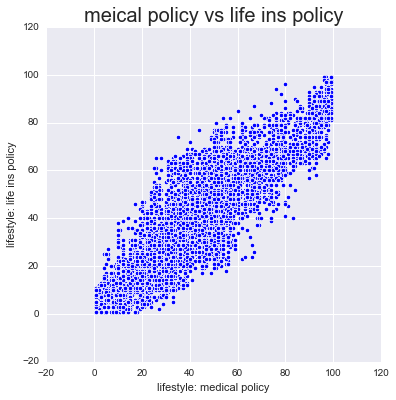

In [456]:
plt.figure(figsize=(6,6))
plt.title("meical policy vs life ins policy", fontsize= 20)
sns.scatterplot(df_num["lifestyle: medical policy"],df_num["lifestyle: life ins policy"])

From the above scatterplot, we can see the strong postive correlation.
<BR>
As one varible increase, the other tend to increase as well.
<BR>
This make sense, since both insurance usually come together.

We can use the same technique to examine other pairs with high correlation as well. By doing so, it might reduce the effect of collinearity for a better model fit in the future.

In [28]:
# drop life ins plicy column
df.drop("lifestyle: life ins policy",axis =1, inplace = True)

## Hypothesis Testing

Since the goal is to find out if there is really a difference between the mean score of Active group and Cancel group. A significance test is needed to get the answer. I will perform the test on two column here, but it can apply to all. Since the sample size is really large in this data,8700 for the active group and 8596 for the cancel group. I will just use Z-test since there will be nearly no differnce in the result.

The null and alternative hypothesis is:

$$ H_0: \mu_\text{Active} =  \mu_\text{Cancel} $$
$$ H_A: \mu_\text{Active} \neq  \mu_\text{Cancel} $$

I will also set the alpha for the Z-test to be 0.02.

The two column to perform the test below will be the "wine lover" and "dog owners" columns 

First I create a z_test function, standard_error function, and hypothesis_test_plot fucntion

In [204]:
def z_test(data1, data2):
    """
    Take two data array, 
    return the z-score and p-value
    
    Parameters
    ----------
    data1: 1-dimensional Array, numpy Array, Pandas Series.
    data2: 1-dimensional Array, numpy Array, Pandas Series.

    Returns
    -------
    dicionary(z-score:value, p-value:value)
    
    """
    numerator = np.mean(data1) - np.mean(data2)
    denominator_sq = (np.var(data1) / len(data1)) + (np.var(data2) / len(data2))
    z_score = numerator / np.sqrt(denominator_sq)
    return {"z-score":z_score,"p-value":"{:.4f}".format(stats.norm.cdf(-abs(z_score)))}

def standard_error(data1,data2):
    """
    Take two data array, 
    return the standard error
    
    Parameters
    ----------
    data1: 1-dimensional Array, numpy Array, Pandas Series.
    data2: 1-dimensional Array, numpy Array, Pandas Series.

    Returns
    -------
    standard error
    
    """
    denominator_sq = (np.var(data1) / len(data1)) + (np.var(data2) / len(data2))
    return np.sqrt(denominator_sq)
    
def hypothesis_test_plot(mu, se, p_value=.02):
    """
    Take in the sample mean, standard error, and a p-value
    return a plot to see if the sampale mean is inside the p-value or not 
    
    Parameters
    ----------
    mu: sample mean
    se: standard error of the data

    Returns
    -------
    a plot for the hypothesis_test
    
    """
    normal = stats.norm(0,se)
    x = np.linspace(-(5*se), 5*se, num=1000)
    plt.figure(figsize=(16, 5))
    plt.plot(x, normal.pdf(x), linewidth=3)
    plt.fill_between(x, normal.pdf(x), 
                where=(x >= normal.ppf(1-p_value)), color="red", alpha=0.5)
    mu = abs(mu)
    plt.plot(mu,0,c="black", marker ="o")
    plt.annotate('Observed Mean Difference = {}'.format(np.round(mu,2)), 
                 xy=(mu, 0),xytext=(mu-3*se,1),arrowprops=dict(facecolor='black',width=0.2,headwidth=9))
    if abs(mu) < normal.ppf(1-p_value):
        plt.title("Since observed data is outside of P-value area, can not reject the Null",fontsize =20)
    else:
        plt.title("Since observed data is insde of P-value area, reject the null",fontsize = 20)


For "wine lover" column, we first look at the shape of data, since it's highly positive skew, I will perform a square root transformation on the data, the result will display below. 

Text(0.5, 1.0, 'KDE Plot for Square Root of Wine Lovers Score, Active vs Cancel')

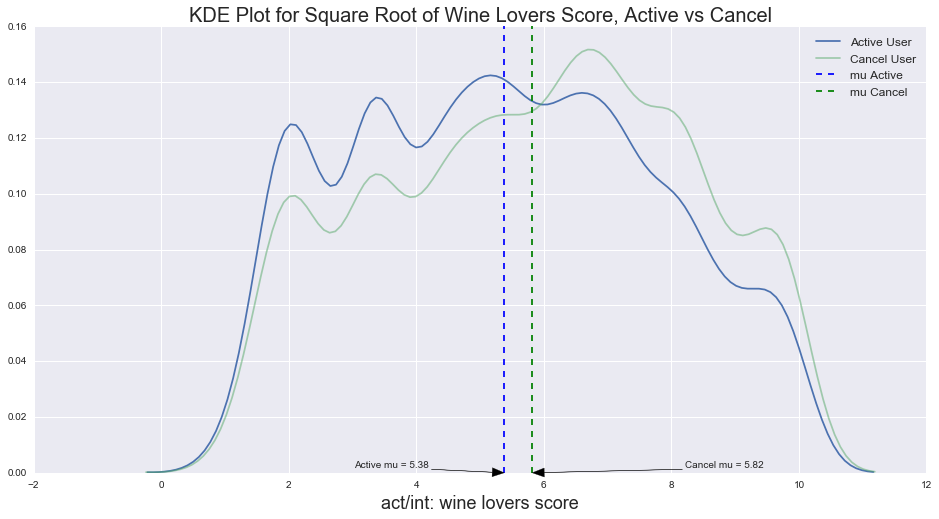

In [446]:
compare_distribution(np.sqrt(df_num_act["act/int: wine lovers"]),np.sqrt(df_num_cnl["act/int: wine lovers"]))
plt.title("KDE Plot for Square Root of Wine Lovers Score, Active vs Cancel",fontsize = 20)

The shape of the data looks symetric after the transformation, so we can approximate the data with a normal distubuiton.

Calling the z-test function to test if mean score of wine lover score between the Active and Cancel user group yields: 

In [451]:
z_test(np.sqrt(df_num_act["act/int: wine lovers"]),
       np.sqrt(df_num_cnl["act/int: wine lovers"]))

{'z-score': -12.196206798024642, 'p-value': '0.0000'}

We get a result of Z = -12.196, p-vluae = 0.

At $\alpha$=0.02, a p-value of 0.0000 means we reject the null hypothesis test, it's really likely there is a difference between the mean wine lover score between the active group and cancel group. 

Apply the same treatment for the dog owner column. 
<BR>
Since the distribution of the data is already symmetric, transformation of data is not needed.

In [452]:
z_test(np.sqrt(df_num_act["act/int: dog owners"]),
       np.sqrt(df_num_cnl["act/int: dog owners"]))

{'z-score': 1.1322649384147367, 'p-value': '0.1288'}

Visual

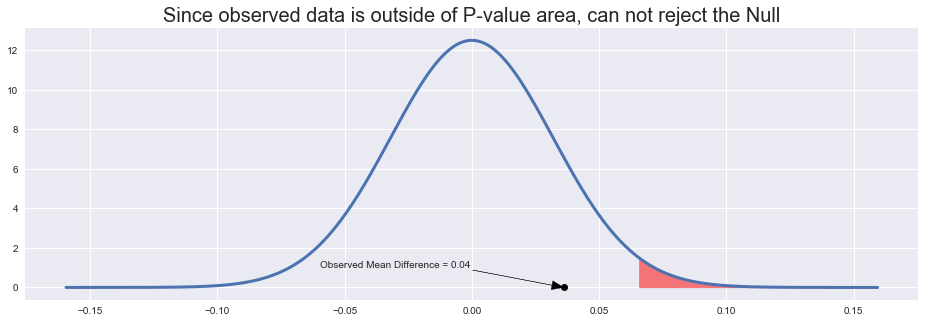

In [88]:
# Caclulte the mean and standard error, call the hypothesis_test_plot function to create the plot
sample_mean = np.mean((np.sqrt(df_num_act["act/int: dog owners"]))) -np.mean(np.sqrt(df_num_cnl["act/int: dog owners"]))
se = standard_error(np.sqrt(df_num_act["act/int: dog owners"]),np.sqrt(df_num_cnl["act/int: dog owners"]))
hypothesis_test_plot(sample_mean,se)


For the dog owner column, we get a result of z = 1.132, p-value = 01288.

At $\alpha$=0.02, a p-value of 0.1288 means we fail to reject the null hypothesis test, we can't say there is a difference between the mean dog owner score between the active and cancel group.  

### Confidence interval
In the above significance test, we conclue there is a likely a difference in mean wine lover score between the two group. <BR>
    
But in order to convince other member in the company to take action on it, it is better to provide a confidence interval, the confidence interval provide more context on how much the expect difference going to be.

In [453]:
def calc_ci(data1, data2, confidence=0.95):
    """
    Take two data arary, the confidence level
    return the confidence interval
    
    Parameters
    ----------
    data1: 1-dimensional Array, numpy Array, Pandas Series.
    data2: 1-dimensional Array, numpy Array, Pandas Series.
    confidence: the Confidence level

    Returns
    -------
    tuple of confidence interval
    
    """
    mu = np.mean(data1) - np.mean(data2)
    se = np.sqrt((np.var(data1) / len(data1)) + (np.var(data2) / len(data2)))
    crit_val = abs(stats.norm.ppf((1-confidence)/2))
    lower = (mu-crit_val*se).round(4)
    upper = (mu+crit_val*se).round(4)
    return (lower,upper)

Call the calc_ci function on the square root of "wine lovers" column

In [454]:
calc_ci(np.sqrt(df_num_act["act/int: wine lovers"]),
       np.sqrt(df_num_cnl["act/int: wine lovers"]))

(-0.5099, -0.3687)

Since this is a square root of the data, the range will be from 1 to 10.

A confidence interval like this mean:
At a scale of 10, we are 95% confidence that the true mean difference between the active group and cancel group is between (-0.5099, -0.3687). In context, the lower the score, the more likely the person is a "Wine Lover", so the active group is more likely to be a wine person.

## Building A Model

By looking at the distribution of each column, there is actually no huge disinclination on the two group of user.
First Build a Simple Logistic Model with all features, see how it looks

The Active user and Expired User is really even.
If every user is guess as Active, the accuracy will be 8244/(8244+8134) = 0.5033, which is about 50%
Our model should do better than that

In [160]:
df["Sub Status"].value_counts()

Series([], Name: Sub Status, dtype: int64)

In [166]:
df["Sub Status"] = df["Sub Status"].map({"Active":1,"Expired/Cancelled":0})

In [179]:
X = df.drop("Sub Status", axis =1)
y = df["Sub Status"]

Split the data to train and test set, reserve 30% of data to test the model

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [36]:
log = LogisticRegression()
logmodel = log.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [38]:
print(classification_report(y_test,logmodel.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      2438
           1       0.58      0.57      0.57      2476

   micro avg       0.57      0.57      0.57      4914
   macro avg       0.57      0.57      0.57      4914
weighted avg       0.57      0.57      0.57      4914



With all the feature used, a accuracy of about 57-58% is observed with the logistic model.

Try Random Forest and Gardient Boost next

In [41]:
rf = RandomForestClassifier(n_estimators=300)

In [42]:
rfmodel = rf.fit(X_train,y_train)

In [43]:
print(classification_report(y_test,rfmodel.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.52      0.55      2438
           1       0.57      0.62      0.59      2476

   micro avg       0.57      0.57      0.57      4914
   macro avg       0.57      0.57      0.57      4914
weighted avg       0.57      0.57      0.57      4914



the random forest model had a similar precision, but better recall on Active User

In [44]:
gb = GradientBoostingClassifier(learning_rate=0.01)

In [45]:
gbmodel = gb.fit(X_train,y_train)

In [46]:
print(classification_report(y_test,gbmodel.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.47      0.52      2438
           1       0.56      0.67      0.61      2476

   micro avg       0.57      0.57      0.57      4914
   macro avg       0.57      0.57      0.57      4914
weighted avg       0.57      0.57      0.57      4914



the gardient boost model also high a higher recall on predicting active user, but lower recall on inactive user

### Since all model is a bit weak,  try to just use feature that has the most difference.

In [53]:
df_diff = pd.DataFrame()
df_diff["active mean"] = df_act.mean()
df_diff["inactive mean"] = df_cnl.mean()
df_diff["Differnce in mean"] = abs(df_diff["active mean"] - df_diff["inactive mean"])
df_diff["sd"] = (np.std(df_act)+np.std(df_cnl))/2
df_diff["mean/sd"] = df_diff["Differnce in mean"]/df_diff["sd"]

In [57]:
df_diff.sort_values("mean/sd", ascending=False).head(10)

,active mean,inactive mean,Differnce in mean,sd,mean/sd
consumerview profitability scr,2.402717,3.004303,0.601586,1.852780,0.324694
tt: in the moment shoppers: hh,7.008127,6.475412,0.532715,1.761754,0.302378
tt: digital video: hh,7.534328,7.001721,0.532607,1.770563,0.300812
tt: novelty seekers: hh,7.257157,6.679739,0.577417,1.991704,0.289911
act/int: hip hop music,70.105895,62.549299,7.556596,26.536587,0.284761
tt: radio: hh,6.984959,6.386403,0.598556,2.141235,0.279538
donor: contrib to political,44.212397,53.546717,9.334321,33.400699,0.279465
inv: active invor,20.083212,26.451193,6.367980,23.026397,0.276551
act/int:eats fast food,71.312227,64.791493,6.520735,23.724994,0.274847
donor: contrib to charities,25.535420,32.353455,6.818035,25.267220,0.269837


In [58]:
select_features = df_diff.sort_values("mean/sd", ascending=False).head(10).index

In [61]:
X_select = df[select_features]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_select, y, test_size=0.3, random_state=101)

In [63]:
log = LogisticRegression()
logmodel = log.fit(X_train,y_train)
print(classification_report(y_test,logmodel.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.49      0.53      2438
           1       0.56      0.65      0.60      2476

   micro avg       0.57      0.57      0.57      4914
   macro avg       0.57      0.57      0.56      4914
weighted avg       0.57      0.57      0.56      4914



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Using the 10 Features I think has the biggest difference create a model that is nearly the same

In [82]:
selector = RFE(log, 1, step=1)
selector = selector.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [83]:
X_rfe = X_select.iloc[:,selector.support_]

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.3, random_state=101)

In [85]:
log = LogisticRegression()
logmodel = log.fit(X_train,y_train)
print(classification_report(y_test,logmodel.predict(X_test)))

              precision    recall  f1-score   support

           0       0.56      0.47      0.51      2438
           1       0.55      0.64      0.59      2476

   micro avg       0.55      0.55      0.55      4914
   macro avg       0.55      0.55      0.55      4914
weighted avg       0.55      0.55      0.55      4914



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


When create a model with just 1 feature using RFE, the model overall performance drop 0.01

### Since the model of 10 feature is nearly the same as all feature, 10 feature will be use, tune hyperparmerer of the model, and get the best outcome

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_select, y, test_size=0.3, random_state=101)

In [104]:
parameters = {
    "learning_rate": [0.002, 0.015,0.003,0.005],
    "n_estimators":[100]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, verbose=3)

In [105]:
clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.002, n_estimators=100 ...........................
[CV]  learning_rate=0.002, n_estimators=100, score=0.5559916274201988, total=   0.5s
[CV] learning_rate=0.002, n_estimators=100 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  learning_rate=0.002, n_estimators=100, score=0.5821559392987964, total=   0.5s
[CV] learning_rate=0.002, n_estimators=100 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  learning_rate=0.002, n_estimators=100, score=0.5732984293193717, total=   0.5s
[CV] learning_rate=0.015, n_estimators=100 ...........................
[CV]  learning_rate=0.015, n_estimators=100, score=0.5596546310832025, total=   0.5s
[CV] learning_rate=0.015, n_estimators=100 ...........................
[CV]  learning_rate=0.015, n_estimators=100, score=0.5803244374672946, total=   0.5s
[CV] learning_rate=0.015, n_estimators=100 ...........................
[CV]  learning_rate=0.015, n_estimators=100, score=0.5756544502617801, total=   0.4s
[CV] learning_rate=0.003, n_estimators=100 ...........................
[CV]  learning_rate=0.003, n_estimators=100, score=0.5562532705389849, total=   0.5s
[CV] learning_rate=0.003, n_estimators=100 ...........................
[CV]  learning_rate=0.003, n_estimators=100, score=0.5829408686551544, total=   0.5s
[CV] learning_rate=0.003, n_estimators=100 ...........................
[CV]  learning_rate=0.003, n_estimators=100, score=0.57382198952

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    5.8s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.002, 0.015, 0.003, 0.005], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [106]:
clf.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.015, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [101]:
gb = GradientBoostingClassifier(n_estimators=100,learning_rate=0.015)

In [102]:
gb.fit(X_train,y_train)
print(classification_report(y_test,gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.45      0.51      2438
           1       0.56      0.68      0.61      2476

   micro avg       0.57      0.57      0.57      4914
   macro avg       0.57      0.57      0.56      4914
weighted avg       0.57      0.57      0.56      4914



## Conclusion

Because the distribution of feature for Active user and Inactive user is not really distinguishable, the model doesn't perform really well. 

An Accuracy of 0.57 is slightly better than random guessing.

To Identify Customer that Churn, a Log Model on all feature is the best, with 0.57 precision and recall.
To Identify Customer that didn't Churn, a Gradient boost model is best with 0.56 precision and 0.68 recall.

Neural Network

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall

In [195]:
model = Sequential()
n_samples, n_feats = X_train.shape

hidden_units = 300
n_classes = 2

hidden_layer = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='relu')

output_layer = Dense(units=n_classes,
                input_dim=hidden_units,
                kernel_initializer='uniform',
                activation='softmax')

model.add(hidden_layer)
model.add(output_layer)


In [196]:
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=[Precision(), Recall()] ) # (keep)

model.fit(X_train, pd.get_dummies(y_train), epochs=35, batch_size=5000, verbose=1,
              validation_split=0.1)

Train on 10317 samples, validate on 1147 samples
Epoch 1/35
10317/10317 [==============================] - 1s 49us/sample - loss: 7.6351 - precision_17: 0.5035 - recall_17: 0.5035 - val_loss: 7.6963 - val_precision_17: 0.4996 - val_recall_17: 0.4996
Epoch 2/35
10317/10317 [==============================] - 0s 22us/sample - loss: 7.6351 - precision_17: 0.5035 - recall_17: 0.5035 - val_loss: 7.6963 - val_precision_17: 0.4996 - val_recall_17: 0.4996
Epoch 3/35
10317/10317 [==============================] - 0s 23us/sample - loss: 7.6351 - precision_17: 0.5035 - recall_17: 0.5035 - val_loss: 7.6963 - val_precision_17: 0.4996 - val_recall_17: 0.4996
Epoch 4/35
10317/10317 [==============================] - 0s 22us/sample - loss: 7.6351 - precision_17: 0.5035 - recall_17: 0.5035 - val_loss: 7.6963 - val_precision_17: 0.4996 - val_recall_17: 0.4996
Epoch 5/35
10317/10317 [==============================] - 0s 23us/sample - loss: 7.6351 - precision_17: 0.5035 - recall_17: 0.5035 - val_loss: 7.69